<a href="https://colab.research.google.com/github/SawsanYusuf/The_Price_of_Netflix_Stocks/blob/main/NFLX_Stocks_Autoregressive_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NFLX Stocks/ Autoregressive Model

In [ ]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
!pip install statsmodels --upgrade

In [3]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

warnings.simplefilter(action="ignore", category=FutureWarning)

## 1. Prepare

### 1.1 Import Data

In [4]:
#Get the stock quote
dataset = web.DataReader('NFLX', data_source='yahoo' )
#show the data
dataset

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-10-12,198.619995,194.710007,196.750000,195.860001,7753300,195.860001
2017-10-13,200.820007,197.190002,199.699997,199.490005,12081300,199.490005
2017-10-16,202.830002,197.860001,201.949997,202.679993,22105400,202.679993
2017-10-17,204.380005,197.770004,200.110001,199.479996,23900100,199.479996
2017-10-18,200.009995,194.250000,199.990005,195.539993,11198900,195.539993
...,...,...,...,...,...,...
2022-10-04,245.800003,233.250000,244.839996,240.740005,13925900,240.740005
2022-10-05,241.589996,227.380005,238.759995,236.729996,10825600,236.729996
2022-10-06,244.279999,233.910004,236.679993,240.020004,9188900,240.020004


In [5]:
df = pd.DataFrame(dataset["Close"])
df.head()

,Close
Date,
2017-10-12,195.860001
2017-10-13,199.490005
2017-10-16,202.679993
2017-10-17,199.479996
2017-10-18,195.539993


In [6]:
y = df["Close"]. resample("1D").mean().fillna(method="ffill")
y.head()

Date
2017-10-12    195.860001
2017-10-13    199.490005
2017-10-14    199.490005
2017-10-15    199.490005
2017-10-16    202.679993
Freq: D, Name: Close, dtype: float64

### 1.2 Explore

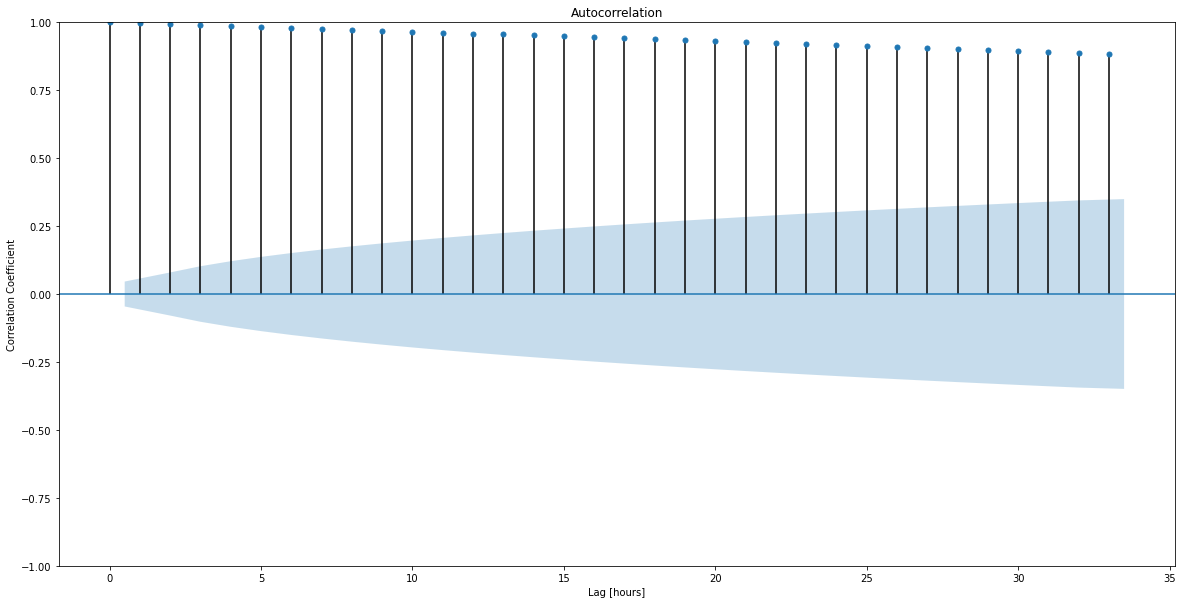

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_acf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

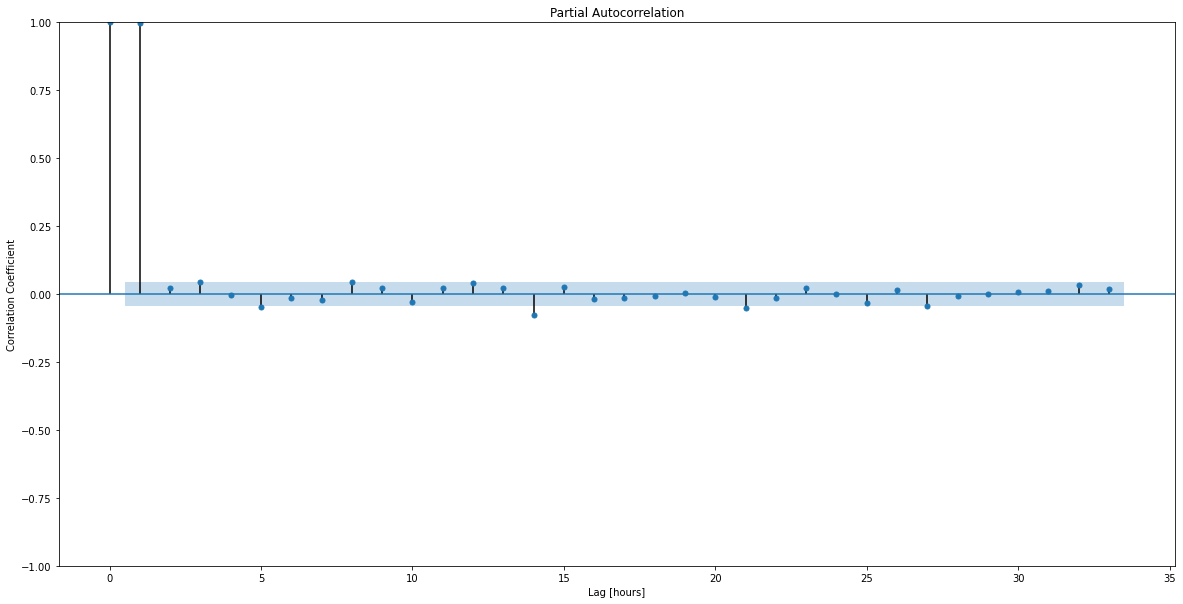

In [11]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_pacf(y, ax = ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

### 1.3 Split

In [19]:
cutoff_test = int(len(y) * 0.95)
y_train = y.iloc[: cutoff_test]
y_test = y.iloc[cutoff_test : ]

## 2. Build Model

###2.1 Baseline

In [20]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Mean Close Price:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean Close Price: 391.52
Baseline MAE: 101.56


### 2.2 Iterate

In [49]:
model = AutoReg(y_train, lags = 3).fit()

In [50]:
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train.iloc[3:], y_pred)
print("Training MAE:", training_mae)

Training MAE: 5.174526414713393


In [51]:
y_train_resid = model.resid
y_train_resid.tail()

Date
2022-07-06   -2.158369
2022-07-07    4.946725
2022-07-08   -2.737528
2022-07-09   -0.308020
2022-07-10   -0.635092
Freq: D, dtype: float64

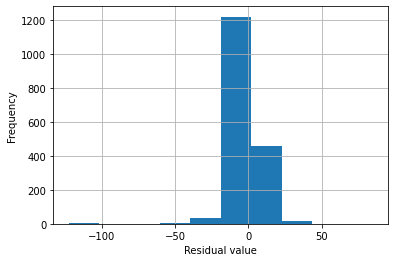

In [52]:
y_train_resid.hist()
plt.xlabel("Residual value")
plt.ylabel("Frequency");

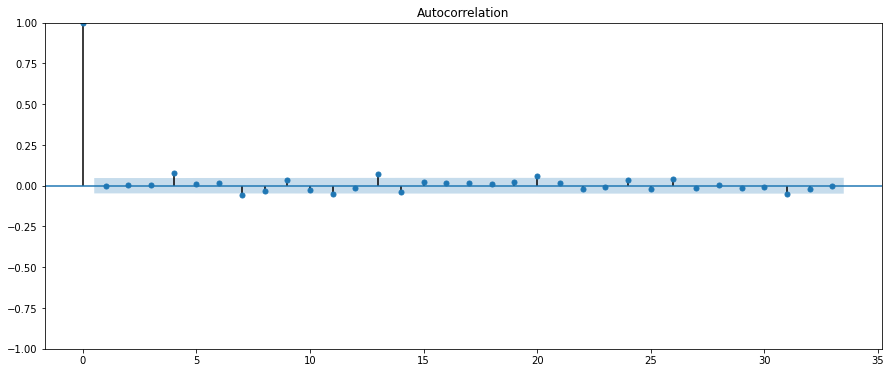

In [53]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax);

###2.3 Evaluate

In [54]:
y_pred_test = model.predict(y_test.index.min(), y_test.index.max())
test_mae = mean_absolute_error(y_test, y_pred_test)
print("Test MAE:", test_mae)

Test MAE: 20.201879977656652


In [62]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
     model = AutoReg(history, lags=3).fit()
     next_pred = model.forecast()
     y_pred_wfv = y_pred_wfv.append(next_pred)
     history = history.append(y_test[next_pred.index])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [63]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 4.12


## 3. Results

In [64]:
print(model.params)

const       1.030766
Close.L1    0.965951
Close.L2   -0.020927
Close.L3    0.052329
dtype: float64


In [66]:
df_pred_test = pd.DataFrame(
{"y_test": y_test, "y_pred_wfv": y_pred_wfv})
df_pred_test.head()

,y_test,y_pred_wfv
2022-07-11,177.339996,187.494162
2022-07-12,174.449997,178.146214
2022-07-13,176.559998,175.559942
2022-07-14,174.779999,177.160823
2022-07-15,189.110001,175.231602


In [67]:
fig = px.line(df_pred_test, labels = {"value": "Adj Close Price"})
fig.show()